In [1]:
import numpy as np
import cv2
import os
import math
import matplotlib.pyplot as plt

In [2]:
folder_task = '/home/xingguang/Documents/ECE661/hw5/images'
images = []
out_path = []
for i in range(1,6):
    path = os.path.join(folder_task, str(i)+'.jpg')
    out_path.append(os.path.join(folder_task, 'matched'+str(i)+'.jpg'))
    images.append(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

In [3]:
def DrawMarker(Img, pList, color=(0,0,255)):
    result = np.copy(Img)
    for j, i in pList:
        result = cv2.circle(result, (j, i), 5, color, 1)
    return result


def cpMatching(f1, f2, method):
    d1 = f1.shape[0]
    d2 = f2.shape[0]
    if method == 'SSD':
        f11 = np.sum(f1*f1, axis=1).reshape((d1, 1))
        f12 = np.dot(f1, f2.T)
        f22 = np.sum(f2*f2, axis=1).reshape((1, d2))
        cp = -f11.repeat(d2, axis=1) + 2 * f12 - f22.repeat(d1, axis=0)
    elif method == 'NCC':
        m1 = np.sum(f1, axis=1, keepdims=True)/f1.shape[1]
        m2 = np.sum(f2, axis=1, keepdims=True)/f2.shape[1]
        nf1 = f1 - m1
        nf2 = f2 - m2
        numerator = np.dot(nf1, nf2.T)
        denom_1 = np.sqrt(np.sum(nf1*nf1, axis=1).reshape((d1, 1)))
        denom_2 = np.sqrt(np.sum(nf2*nf2, axis=1).reshape((1, d2)))
        denominator = np.dot(denom_1, denom_2)
        cp = numerator / denominator
    else: print("\'Method\' has to be SSD or NCC")
    f1_Matching = np.argmax(cp, axis=1)
    f2_Matching = np.argmax(cp, axis=0)
    return cp, f1_Matching, f2_Matching


def matchedImg(img1, img2, pList1, pList2, idx1, idx2):
    def drawLines(img, p_start, p_end, color=(0,255,0)):
        image = np.copy(img)
        for i in range(len(p_start)):
            image = cv2.circle(image, p_start[i], 3, color, 1)
            image = cv2.circle(image, p_end[i], 3, color, 1)
            image = cv2.line(image, p_start[i], p_end[i], color, 2) 
        return image

    im1 = np.copy(img1)
    im2 = np.copy(img2)

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    if h1 > h2:
        im2 = cv2.copyMakeBorder(im2, 0, h1-h2, 0, 0, cv2.BORDER_REPLICATE)
        h = h1
    elif h1 < h2:
        im1 = cv2.copyMakeBorder(im1, 0, h2-h1, 0, 0, cv2.BORDER_REPLICATE)
        h = h2
    else: h = h1

    if w1 > w2:
        im2 = cv2.copyMakeBorder(im2, 0, 0, 0, w1-w2, cv2.BORDER_REPLICATE)
        w = w1
    elif w1 < w2:
        im1 = cv2.copyMakeBorder(im1, 0, 0, 0, w2-w1, cv2.BORDER_REPLICATE)
        w = w2
    else: w = w1

    concatIm = np.concatenate((im1, im2), axis=1)
    npList2 = [(j+w, i) for (j, i) in pList2]
    concatIm = DrawMarker(concatIm, pList1, color=(255,0,0))
    concatIm = DrawMarker(concatIm, npList2, color=(255,0,0))

    bestMatch_1 = [pList1[i] for i in idx1]
    bestMatch_2 = [npList2[i] for i in idx2]
    print('detected '+str(len(pList1))+ ' corners in image 1')
    print('detected '+str(len(pList2))+ ' corners in image 2')
    print('found '+str(len(bestMatch_1))+ ' matched corners between image 1 and 2')
    matchedIm = drawLines(concatIm, bestMatch_1, bestMatch_2, color=(255,0,0))
    return concatIm, matchedIm


def SIFTmatching(img1, img2, nfeatures=100, max_pairs=100):
    g_1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    g_2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    sift = cv2.xfeatures2d.SIFT_create(nfeatures,
                                        nOctaveLayers=4,
                                        contrastThreshold=0.05,
                                        edgeThreshold=10,
                                        sigma=2)
    kp1, des1 = sift.detectAndCompute(g_1, None)
    kp2, des2 = sift.detectAndCompute(g_2, None)
    pList1 = [(int(kp1[i].pt[0]), int(kp1[i].pt[1])) for i in range(len(kp1))]
    pList2 = [(int(kp2[i].pt[0]), int(kp2[i].pt[1])) for i in range(len(kp2))]
    cp, idn_1, idn_2 = cpMatching(des1, des2, method='NCC')
    pidxList1, pidxList2, score = [], [], []
    for i, idx2 in enumerate(idn_1):
        if i==idn_2[idx2]:
            pidxList1.append(i)
            pidxList2.append(idx2)
            score.append(cp[i, idx2])
    zipped = list(zip(score, pidxList1, pidxList2))
    zipped.sort(reverse=True)
    score, pidxList1, pidxList2 = zip(*zipped)
    concatIm, matchedIm = matchedImg(img1, img2, pList1, pList2, pidxList1[:max_pairs], pidxList2[:max_pairs])
    matchedcorners1 = np.asarray([(kp1[i].pt[0], kp1[i].pt[1]) for i in pidxList1[:max_pairs]])
    matchedcorners2 = np.asarray([(kp2[i].pt[0], kp2[i].pt[1]) for i in pidxList2[:max_pairs]])
    return concatIm, matchedIm, matchedcorners1, matchedcorners2

In [4]:
def findHomoproj(source, target):
    def F_unit(source_point, target_point):
        x, y = source_point[0], source_point[1]
        x_, y_ = target_point[0], target_point[1]
        return np.asarray([[x, y, 1, 0, 0, 0, -x*x_, -y*x_], 
                        [0, 0, 0, x, y, 1, -x*y_, -y*y_]])
    F_list = [F_unit(source[i], target[i]) for i in range(source.shape[0])]
    F = np.concatenate(F_list, axis=0)
    T_span = target.reshape((-1,1))
    H_param = np.dot(np.linalg.pinv(F), T_span)
    H = np.ones((9, 1))
    H[:8, :] = H_param
    return H.reshape((3, 3))


def findInliers(src, tgt, H, dt):
    nps = src.shape[0]
    X = np.concatenate((src, np.ones((nps,1))), axis=1)
    Y_ = np.dot(H, X.T).T
    Y_ = Y_ / Y_[:,2].reshape((nps,1))
    e = tgt - Y_[:,:2]
    e_norm = np.linalg.norm(e, axis=1)
    idx_in = np.where(e_norm<=dt)
    num_in = idx_in[0].shape[0]
    return idx_in, num_in


def markInliers(img, sp, tp, idx, color=(0,255,0)):
    image = np.copy(img)
    w = int(img.shape[1]/2)
    for i in idx:
        p_start = (int(sp[i,0]), int(sp[i,1]))
        p_end = (int(tp[i,0] + w), int(tp[i,1]))
        image = cv2.circle(image, p_start, 3, color, 1)
        image = cv2.circle(image, p_end, 3, color, 1)
        image = cv2.line(image, p_start, p_end, color, 2) 
    return image


def RANSAC(src, tgt, dt, n, p, ep):
    n_total = src.shape[0]
    M = int((1 - ep) * n_total)
    N = int(math.log(1-p) / math.log(1-(1-ep)**n))
    max_inlier = 0
    found_idx = ()
    for i in range(N):
        idx = np.random.randint(0, n_total, n)
        src_trial = src[idx]
        tgt_trial = tgt[idx]
        H_homo = findHomoproj(src_trial, tgt_trial)
        idx_in, num_in = findInliers(src, tgt, H_homo, dt)
        if num_in > max_inlier:
            max_inlier = num_in
            found_idx = idx_in
    H_RANSAC = findHomoproj(src[found_idx], tgt[found_idx])
    if max_inlier >= M:
        print('found at most', max_inlier, 'inliers')
    else:
        print('No enough inliers detected! Require at least', M, 'but found', max_inlier)
    return H_RANSAC, found_idx[0]

In [5]:
def findJacobian(source, target, H):
    def J_unit(source_point, target_point):
        x, y = source_point[0], source_point[1]
        x_, y_, w_ = target_point[0], target_point[1], target_point[2]
        w_2 = w_ ** 2
        return np.asarray([[x/w_, y/w_, 1/w_, 0, 0, 0, -x*x_/w_2, -y*x_/w_2, -x_/w_2], 
                        [0, 0, 0, x/w_, y/w_, 1/w_, -x*y_/w_2, -y*y_/w_2, -y_/w_2]])

    nps = source.shape[0]
    source_rep = np.concatenate((source, np.ones((nps,1))), axis=1)
    tgt_rep = np.dot(H, source_rep.T).T
    J_list = [J_unit(source[i], tgt_rep[i]) for i in range(nps)]
    J = np.concatenate(J_list, axis=0)
    tgt_norm = tgt_rep[:,:2] / tgt_rep[:,2].reshape((nps,1))
    E = target - tgt_norm.reshape((-1,))
    return J, E


def getError(src, tgt, H):
    nps = src.shape[0]
    source_rep = np.concatenate((src, np.ones((nps,1))), axis=1)
    tgt_rep = np.dot(H, source_rep.T).T
    tgt_norm = tgt_rep[:,:2] / tgt_rep[:,2].reshape((nps,1))
    E = tgt - tgt_norm.reshape((-1, ))
    e = np.dot(E.T, E)
    return e


def projTransform(H, source, flatten=True):
    nps = source.shape[0]
    source_rep = np.concatenate((source, np.ones((nps,1))), axis=1)
    t_homo = np.dot(H, source_rep.T).T
    t_norm = t_homo[:,:2] / t_homo[:,2].reshape((nps,1))
    if flatten:
        return t_norm.reshape((-1,))
    else:
        return t_norm

def LM_Refine(src_pts, tgt, H_init, ep, tau=0.5):
    I = np.identity(9)
    tgt = tgt.reshape((-1,))
    
    #Initialize parameters
    J, ek = findJacobian(src_pts, tgt, H_init)
    mu_init = tau * np.max(np.diagonal(np.dot(J.T, J)))
    mu = mu_init
    H_k = H_init
    step = 0
    errors = []
    delta_norm = 1
    while delta_norm >= ep:
        #Calculation of cost function C and error ek at time step k
        Cp = getError(src_pts, tgt, H_k)
        #Calculation of delta
        J, ek = findJacobian(src_pts, tgt, H_k)
        delta = np.dot(np.dot(np.linalg.inv(np.dot(J.T, J) + mu * I), J.T), ek)  
        delta_norm = np.linalg.norm(delta)
    
        #Calculation of cost function and error at time step k+1
        H_k1 = H_k + delta.reshape((3, 3))
        Cp_next = getError(src_pts, tgt, H_k1)
        errors.append(Cp_next)

        rho_num = Cp - Cp_next
        rho = rho_num / (np.dot(np.dot(delta, J.T), ek) + np.dot(np.dot(delta, mu * I), delta))
        #Update damping coefficient
        mu_next = mu * max(1 / 3, 1 - (2 * rho - 1) ** 3)
        print("step =", step, "  mu =", mu, "  delta_norm =", delta_norm, " Cp =", Cp)

        #Reassign values
        step += 1
        mu = mu_next
        if mu == np.inf:
            break
        if rho_num >= 0:
            H_k = H_k1

    H_NonLinear = H_k
    return H_NonLinear, errors

detected 500 corners in image 1
detected 500 corners in image 2
found 100 matched corners between image 1 and 2
found at most 96 inliers
[[ 1.35084040e+00 -4.63924042e-02 -4.26771912e+02]
 [ 2.79503842e-01  1.22202298e+00 -1.58989603e+02]
 [ 3.84280162e-04 -1.15298697e-05  1.00000000e+00]]


&lt;matplotlib.image.AxesImage at 0x7f1533a6aa90&gt;

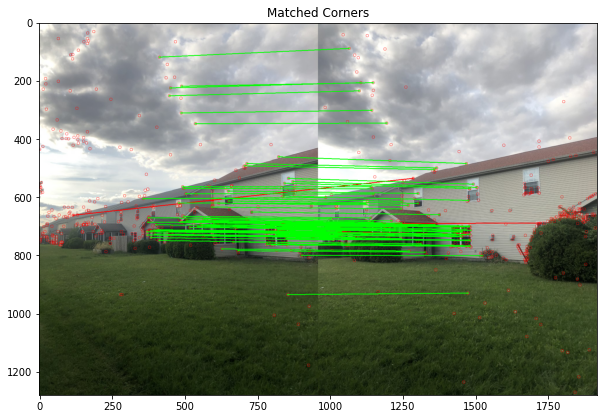

In [6]:
_, matchedIm, corners1, corners2 = SIFTmatching(images[0], images[1], 500, 100)
dt = 10
n = 6
p = 0.999
ep = 0.2
H, in_idx = RANSAC(corners1, corners2, dt, n, p, ep)
filteredIm = markInliers(matchedIm, corners1, corners2, in_idx)
print(H)
plt.figure(figsize=(10,20))
plt.title('Matched Corners')
plt.imshow(filteredIm)

In [7]:
def filterH(H_list, center):
    H_num = len(H_list)
    left = H_list[:center]
    right = [np.linalg.inv(H) for H in H_list[center:]]
    if center >= 2:
        left.reverse()
        for i in range(1, center):
            left[i] = np.dot(left[i], left[i-1])
        left.reverse()
    if center < H_num-1:
        for i in range(1, H_num - center):
            right[i] = np.dot(right[i], right[i-1])
    return left + [np.eye(3)] + right

def findRange(h, w, H_list):
    original_range = np.asarray([[0,0], [w, 0], [w, h], [0, h]])
    ranges = []
    for H in H_list:
        new_range = projTransform(H, original_range, flatten=False).astype(int)
        ranges.append(new_range)
    return ranges

def projRange(source, target, H, srange, offsetH, offsetW):
    mask = np.zeros_like(source)
    srange -= np.asarray([[offsetW, offsetH]])
    mask = cv2.fillPoly(mask,[srange],(255,255,255))
    for i in range(source.shape[0]):
        for j in range(source.shape[1]):
            if any(mask[i][j]) > 0:
                coor_source = np.asarray([[j+offsetW, i+offsetH]])
                coor_target = projTransform(H, coor_source, flatten=False).squeeze()
                source[i,j,:] = target[int(coor_target[1]), int(coor_target[0]),:]
    return source, mask


def stitch(images, H_list, center=2):
    h, w = images[0].shape[0], images[0].shape[1]
    new_list = filterH(H_list, center)
    ranges = findRange(h-1, w-1, new_list)
    vertices = np.concatenate(ranges, axis=0)

    l, r = np.amin(vertices[:, 0]), np.amax(vertices[:, 0])
    t, b = np.amin(vertices[:, 1]), np.amax(vertices[:, 1])
    new_W = r-l
    new_h = b-t
    offsetW = l
    offsetH = t
    template = np.zeros((new_h, new_W, 3))

    for img_idx in range(len(images)):
        srange = ranges[img_idx]
        template, mask = projRange(template, images[img_idx], np.linalg.inv(new_list[img_idx]), srange, offsetH, offsetW)
    result = cv2.cvtColor(template.astype('uint8'), cv2.COLOR_RGB2BGR)
    return result

In [16]:
H_list = []
for i in range(4):
    _, matchedIm, corners1, corners2 = SIFTmatching(images[i], images[i+1], 500, 100)
    dt = 10
    n = 6
    p = 0.999
    ep = 0.1
    thr = 1e-23
    H, in_idx = RANSAC(corners1, corners2, dt, n, p, ep)
    filteredIm = markInliers(matchedIm, corners1, corners2, in_idx)
    H_refined, errors = LM_Refine(corners1[in_idx], corners2[in_idx], H, thr)
    # H_refined = refine(corners1[in_idx], corners2[in_idx], H)
    H_list.append(H_refined)
    # cv2.imwrite(out_path[i], cv2.cvtColor(filteredIm, cv2.COLOR_RGB2BGR))

detected 500 corners in image 1
detected 500 corners in image 2
found 100 matched corners between image 1 and 2
found at most 96 inliers
detected 500 corners in image 1
detected 500 corners in image 2
found 100 matched corners between image 1 and 2
No enough inliers detected! Require at least 90 but found 89
detected 500 corners in image 1
detected 500 corners in image 2
found 100 matched corners between image 1 and 2
found at most 94 inliers
detected 500 corners in image 1
detected 500 corners in image 2
found 100 matched corners between image 1 and 2
found at most 98 inliers


In [17]:
result = stitch(images, H_list, center=2)
cv2.imwrite('/home/xingguang/Documents/ECE661/hw5/images/panoramic.jpg', result)

True

&lt;matplotlib.image.AxesImage at 0x7f14e59e8828&gt;

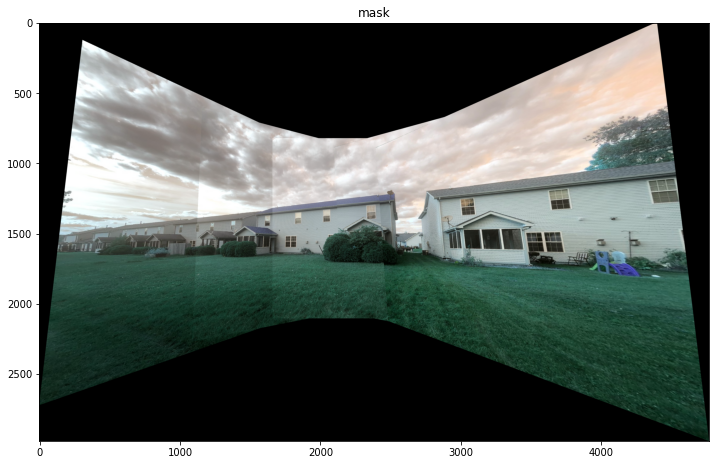

In [18]:
plt.figure(figsize=(12,20))
plt.title('mask')
plt.imshow(result)

In [14]:
def refine(corners1, corners2, H):
    import scipy.optimize

    def Loss_Func(h, Corres):  # Corres in (n, 4)
        Homo = np.array([[h[0], h[1], h[2]], [h[3], h[4], h[5]], [h[6], h[7], 1]])
        X = Corres[:,0:2] 
        X_GT = Corres[:,2:4]
        X_Transpose = np.transpose(X)
        X3D = np.ones((3, Corres.shape[0]))
        X3D[0:2, :] = X_Transpose
        MappedX3D = np.dot(Homo, X3D)
        MappedX2D_T = np.transpose(MappedX3D[0:2, :]/MappedX3D[2,:])
        return (MappedX2D_T - X_GT).flatten()

    corners = np.concatenate((corners1, corners2), axis=1)
    h_init = [H[0, 0], H[0,1], H[0,2], H[1,0], H[1,1], H[1,2], H[2,0], H[2,1]]
    sol = scipy.optimize.least_squares(Loss_Func, h_init, method = 'lm', args = [corners])
    H_LLS = np.array([[sol.x[0], sol.x[1], sol.x[2]], 
                        [sol.x[3], sol.x[4], sol.x[5]], 
                        [sol.x[6], sol.x[7], 1]])
    return H_LLS